In [1]:
import sys

sys.path.append('../../')

In [2]:
from analysis_functions import test_after_opt, split_transform_one_comp_cv, opener

In [3]:
# Load data
X_stress_components_new = opener(
    "X_stress_components_new_components", path_import="../../new_components_resources/"
)
y_stress_components_new = opener(
    "y_stress_components_new_components", path_import="../../new_components_resources/"
)

print(X_stress_components_new.shape)

component_num = 0
# n_trials = 200

# Проверяем доступность GPU
# use_gpu = torch.cuda.is_available()
# device = "cuda" if use_gpu else "cpu"
# print(f"Используется устройство: {device}")

# Данные для текущего компонента
X_current = X_stress_components_new[component_num]
y_current = y_stress_components_new[component_num]

../../new_components_resources//X_stress_components_new_components.pkl
../../new_components_resources//y_stress_components_new_components.pkl
(3, 1597, 5)


In [4]:
# Example usage:
import sys

sys.path.append('../../')
import torch
from gpu_optuna import do_optuna_pytorch, test_best_model_pytorch, predict_with_model
# Step 1: Run hyperparameter optimization
# best_params, X_test, y_test, best_value = do_optuna_pytorch(
#     X_current, y_current, n_trials=50
# )


torch.manual_seed(42)  # Set a fixed seed for reproducibility

best_mlp_params = {
    "n_layers": 3,
    "n_units_0": 52,
    "n_units_1": 43,
    "n_units_2": 71,
    "activation": "tanh",
    "learning_rate": 0.01551343676461695,
    "batch_size": 32768,
    "optimizer": "LBFGS",
    "max_epochs": 262,
}

# Step 2: Train and evaluate a model with the best hyperparameters
model, test_metrics, mean, std, errors = test_best_model_pytorch(
    X_current, y_current, best_mlp_params
)


Using device: cpu
Epoch 0/262, Train Loss: 5288.560059, Test Loss: 5368.838379
Epoch 20/262, Train Loss: 81.781166, Test Loss: 84.727005
Epoch 40/262, Train Loss: 35.820324, Test Loss: 50.591732
Epoch 60/262, Train Loss: 23.008461, Test Loss: 37.720554
Epoch 80/262, Train Loss: 18.536087, Test Loss: 32.661129
Epoch 100/262, Train Loss: 16.782492, Test Loss: 31.861055
Epoch 120/262, Train Loss: 14.964770, Test Loss: 30.482780
Epoch 140/262, Train Loss: 13.882777, Test Loss: 29.443581
Early stopping at epoch 156, Train Loss: 13.183284, Test Loss: 29.389690

Test Metrics:
Explained Variance Score: 0.994944
Median Absolute Error: 2.050882
Mean Squared Error: 29.389687
Mean Absolute Error: 3.321114
R² Score: 0.994932
Max Error: 44.514626
AIC: 77523.582857
BIC: 85537.716930
RMSE: 5.421226


In [5]:
# Step 3: Save the model
model_path = "models/mlp_regressor_model_0.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/mlp_regressor_model_0.pth


In [6]:
# Step 4: Load the model
# Make sure you have the model class definition (MLPNetwork from gpu_optuna.py or similar)
# and the parameters it was initialized with (e.g., input_size, output_size, best_mlp_params for hidden layers)

# Assuming 'MLPNetwork' is the model class and it's imported
# You would need to know the input_size and output_size, or retrieve them dynamically
# For this example, let's assume they are known or can be inferred from X_current and y_current

# Example: Determine input_size and output_size from data (if not already known)
input_size = 6
output_size = 1

# Instantiate the model with the same architecture
# You'll need to import your model class, e.g., from gpu_optuna import MLPNetwork
# This assumes MLPNetwork is defined in gpu_optuna and takes these params
# You might need to adjust this based on your actual MLPNetwork class definition
from gpu_optuna import MLPNetwork  # Make sure this import is correct for your project

loaded_model = MLPNetwork(
    layer_sizes=[input_size]
    + [best_mlp_params[f"n_units_{i}"] for i in range(best_mlp_params["n_layers"])]
    + [output_size],
    activation=best_mlp_params["activation"],
)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (important for inference)
loaded_model.eval()

print(f"Model loaded from {model_path} and set to evaluation mode.")

# You can now use loaded_model for predictions, for example:
# predictions_with_loaded_model = predict_with_model(loaded_model, X_test, mean, std)

Model loaded from models/mlp_regressor_model_0.pth and set to evaluation mode.


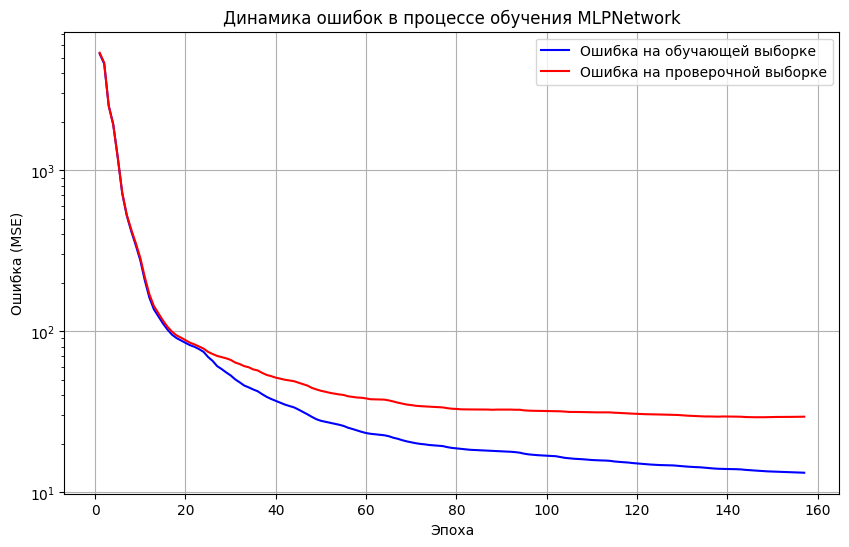

In [7]:
# Визуализация метрик обучения и валидации
import matplotlib.pyplot as plt
import numpy as np

# Получаем данные об ошибках обучения и валидации
train_losses = errors['train_losses']
test_losses = errors['test_losses']

# Создаем массив эпох
epochs = np.arange(1, len(train_losses) + 1)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Ошибка на обучающей выборке', color='blue')
plt.plot(epochs, test_losses, label='Ошибка на проверочной выборке', color='red')
plt.title('Динамика ошибок в процессе обучения MLPNetwork')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка (MSE)')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Используем логарифмическую шкалу для лучшей визуализации
plt.show()

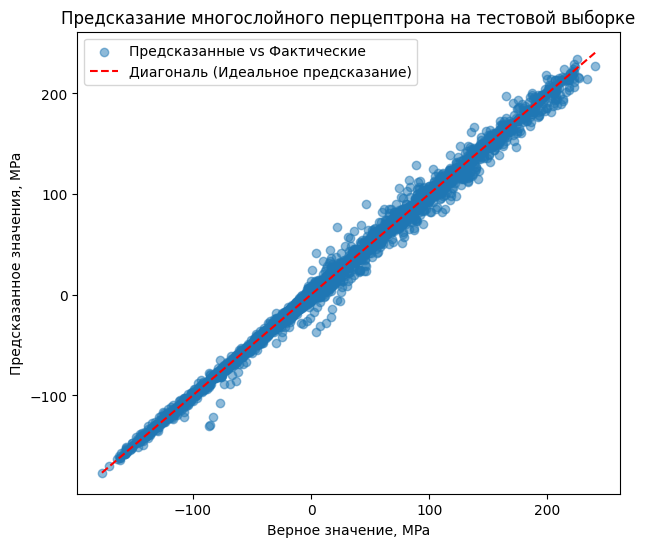

In [8]:
# Визуализация результатов предсказания модели
import numpy as np
import matplotlib.pyplot as plt
from analysis_functions import clean_input_array
# Применяем обученную модель к тестовым данным
X_test, y_test, _, _, _, _ = split_transform_one_comp_cv(X_current, y_current, n_splits=1)
X_test, y_test = clean_input_array(X_test, y_test)

# Получаем предсказания
predictions = predict_with_model(model, X_test, mean, std)

# Строим график сравнения предсказанных и фактических значений
plt.figure(figsize=(7, 6))
plt.scatter(y_test, predictions, alpha=0.5, label='Предсказанные vs Фактические')

# Добавляем диагональную линию (идеальное предсказание)
min_val = min(np.min(y_test), np.min(predictions))
max_val = max(np.max(y_test), np.max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Диагональ (Идеальное предсказание)')

plt.title('Предсказание многослойного перцептрона на тестовой выборке')
plt.xlabel('Верное значение, MPa')
plt.ylabel('Предсказанное значения, MPa')
plt.legend()
# plt.grid(True)
plt.savefig(f"best_mlp_prediction_{component_num}.png", dpi=400)
plt.show()